In [1]:
import pandas as pd
pd.options.display.max_columns=999
pd.options.display.max_rows=999
import pandas_profiling
from collections import Counter, defaultdict
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%reload_ext autoreload
%autoreload 2
from tqdm import tqdm_notebook, trange
import pickle
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from glob import glob
from itertools import chain
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_curve
from scipy.spatial.distance import pdist, cdist
import datetime

In [4]:
review_df = pd.read_csv('src/amzn_fake_review_star_correct_302066.csv')

In [5]:
review_df.shape

(302066, 5)

In [6]:
review_df.head()

,review_id,en_segment,th_segment,correct,review_star
0,1-333090,Good quality product at reasonable price.,สินค้าคุณภาพดีในราคาที่เหมาะสม,1.0,4.0
1,1-57783,They do NOT last more than 10 bottles.,พวกเขาไม่เกิน 10 ขวด,0.0,1.0
2,1-319174,If you like post-apocalyptic fiction with a tw...,ถ้าคุณชอบนิยายหลังเลิกเรียนด้วยการบิดนี่คือมัน,0.0,4.0
3,1-425331,Was a little worried when purchasing due to so...,รู้สึกกังวลเล็กน้อยเมื่อซื้อเนื่องจากรีวิวบางอ...,0.0,4.0
4,1-134583,I had heard from relatives who have read this ...,ฉันได้ยินจากญาติที่อ่านหนังสือเล่มนี้ว่าพ่อแม่...,1.0,2.0


In [7]:
# show random en_segment / th_segment
rand_idx = np.random.randint(len(review_df))
print('comment: {}\nis_correct: {}\nreview star:{}'.format(review_df.iloc[rand_idx]['th_segment'],
      review_df.iloc[rand_idx]['correct'],
      review_df.iloc[rand_idx]['review_star']))

comment: ในฐานะนักเดินทางระยะไกลที่อาศัยอยู่ในอิตาลีฉันโชคดีที่ได้ยินเพลงของนักร้องที่สวยงามจริงๆที่นี่ แต่เมื่อเปรียบเทียบกับโลกโอเปร่าไม่มีการเปรียบเทียบMs. Gheorghiu มีเครื่องดนตรีจริงหนึ่งเสียงซึ่งเธอปรับใช้อย่างสวยงามโดยเฉพาะในการบันทึกนี้นี่จะเป็นหนึ่งในบันทึกที่มีค่าของฉัน
is_correct: 0.0
review star:4.0


In [10]:
review_df.isna().sum()

review_id      0
en_segment     0
th_segment     0
correct        0
review_star    0
dtype: int64

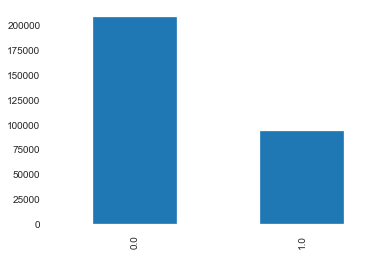

In [35]:
review_df['correct'].value_counts().plot(kind='bar')

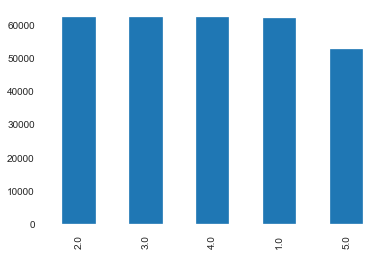

In [36]:
review_df['review_star'].value_counts().plot(kind='bar')

In [2]:
from pythainlp.ulmfit import *

Corpus: wiki_lm_lstm
- Downloading: wiki_lm_lstm 0.32


100%|██████████| 1050919089/1050919089 [29:15<00:00, 598482.49it/s] 


Corpus: wiki_itos_lstm
- Downloading: wiki_itos_lstm 0.32


100%|██████████| 1530484/1530484 [00:00<00:00, 1601750.63it/s]


In [21]:
review_df["processed"] = review_df['th_segment'].map(lambda x: "|".join(process_thai(x)))
review_df["wc"] = review_df['processed'].map(lambda x: len(x.split("|")))
review_df["uwc"] = review_df['processed'].map(lambda x: len(set(x.split("|"))))

In [2]:
import os
# save tokenized review
# os.makedirs('tmp',exist_ok=True)
# review_df.to_csv('tmp/review_df_check-point-1.csv',index=False)

review_df = pd.read_csv('tmp/review_df_check-point-1.csv')

Train/valid split

In [3]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(review_df, test_size=0.15)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [4]:
#prevalence
train_df["correct"].value_counts(normalize=True)

0.0    0.688514
1.0    0.311486
Name: correct, dtype: float64

In [5]:
#prevalence
valid_df["correct"].value_counts(normalize=True)

0.0    0.6887
1.0    0.3113
Name: correct, dtype: float64

Logistic regression

In [6]:
#dependent variables
y_train = train_df["correct"]
y_valid = valid_df["correct"]

In [7]:
#text faetures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [9]:
tfidf = TfidfVectorizer(tokenizer=lambda x:x.split('|'), ngram_range=(1,2), max_features=25_000, sublinear_tf=True)
# tfidf_fit = tfidf.fit(all_df["texts"])
text_train = tfidf.fit_transform(train_df["processed"])
text_valid = tfidf.transform(valid_df["processed"])
text_train.shape, text_valid.shape

((256756, 25000), (45310, 25000))

In [10]:
#word count and unique word counts; actually might not be so useful
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_train = scaler.fit_transform(train_df[["wc","uwc"]].astype(float))
num_valid = scaler.transform(valid_df[["wc","uwc"]].astype(float))
num_train.shape, num_valid.shape

((256756, 2), (45310, 2))

In [11]:
#concatenate text and word count features
X_train = np.concatenate([num_train,text_train.toarray()],axis=1)
X_valid = np.concatenate([num_valid,text_valid.toarray()],axis=1)
X_train.shape, X_valid.shape

((256756, 25002), (45310, 25002))

In [12]:
#fit logistic regression models
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train,y_train)
model.score(X_valid,y_valid)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

0.7160450231736923

In [14]:
probs = model.predict_proba(X_valid)
probs_df = pd.DataFrame(probs)
probs_df.columns = model.classes_
probs_df["preds"] = model.predict(X_valid)
probs_df["correct"] = valid_df['correct']
probs_df["th_segment"] = valid_df['th_segment']
probs_df["processed"] = valid_df['processed']
probs_df["wc"] = valid_df['wc']
probs_df["uwc"] = valid_df['uwc']
probs_df["hit"] = (probs_df['preds']==probs_df['correct'])
probs_df.to_csv("tmp/probs_df_linear.csv", index=False)

In [15]:
probs_df.head()

,0.0,1.0,preds,correct,th_segment,processed,wc,uwc,hit
0,0.807132,0.192868,0.0,1.0,เหตุผลเดียวที่ทำให้มันได้รับสามดาวก็เพราะว่ามั...,เหตุผล|เดียว|ที่|ทำให้|มัน|ได้รับ|สาม|ดาว|ก็เพ...,50,43,False
1,0.665240,0.334760,0.0,1.0,ซื้อและลองสิ่งนี้เมื่อหน่วยเก่าของฉันล้มเหลว (...,ซื้อ|และ|ลอง|สิ่ง|นี้|เมื่อ|หน่วย|เก่า|ของ|ฉัน...,28,28,False
2,0.272429,0.727571,1.0,0.0,ฉันดีใจที่ฉันไม่ได้จ่ายอะไรเลย,ฉัน|ดีใจ|ที่|ฉัน|ไม่ได้|จ่าย|อะไร|เลย,8,7,False
3,0.864635,0.135365,0.0,0.0,ไม่ชอบสไตล์การเขียนของผู้เขียนรู้สึกว่ามันสื่อ...,ไม่|ชอบ|สไตล์|การเขียน|ของ|ผู้เขียน|รู้สึก|ว่า...,83,71,True
4,0.915618,0.084382,0.0,0.0,ฉันมีสุนัขตัวใหญ่มาก - £ 12 และปลอกคอนี้จะไม่พ...,ฉัน|มี|สุนัข|ตัว|ใหญ่|มาก|-|£|12|และ|ปลอกคอ|นี...,73,55,True


0.7160450231736923


Text(30.5, 0.5, 'Actual')

Text(0.5, 12.5, 'Predicted')

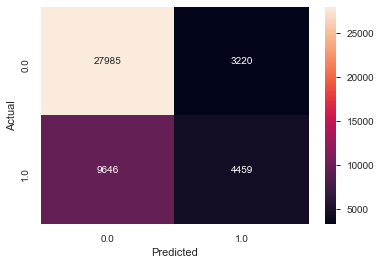

In [17]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(probs_df['correct'],probs_df['preds'])
print(model.score(X_valid,y_valid))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [4]:
from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback
from pythainlp.ulmfit import *

In [5]:
model_path = "output/"
review_df = pd.read_csv('src/amzn_fake_review_star_correct_302066.csv')
train_df, valid_df = train_test_split(review_df, test_size=0.15)

In [6]:
tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=2)]

data_lm = (TextList.from_df(train_df, model_path, cols="th_segment", processor=processor)
    .split_by_rand_pct(valid_pct = 0.01, seed = 1412)
    .label_for_lm()
    .databunch(bs=48))
data_lm.sanity_check()
# data_lm.save('amazon_fake_review_lm.pkl')

In [7]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=1., clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**_THWIKI_LSTM)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (254189 items)
x: LMTextList
xxbos   ฉัน ชอบ ผลิตภัณฑ์ และ ราคา มัน แพง ไป ดังนั้น ฉัน อาจ เปลี่ยนสี หรือ ขนาดที่ ใหญ่ กว่า,xxbos   มัน เป็น หนังสือ ที่ ดี   แต่ ไม่ใช่ สิ่ง ที่ ฉัน คาดหวัง ไม่ คุ้ม กับ ราคา เมื่อ เทียบ กับ หนังสือ อื่น   ๆ   ที่ คล้าย กัน หาก ใคร ต้องการ มัน ฟรี ไป เลย เพียง จำไว้ ว่า มี ตัวเลือก ที่ ดีกว่า,xxbos   มันดี ใน ตอนแรก   แต่ หลังจาก ผ่าน ไป ระยะ หนึ่ง มัน ก็ เริ่ม กระจุย กับ ฉัน   ...   ฉัน คิด ว่า คุณ จะ ได้รับ สิ่ง ที่ คุณ จ่าย ไป,xxbos   ฉัน ทำ การวิจัย มากมาย ก่อน ตัดสินใจ ซื้อ ฉัน ไม่เคย มี มา ก่อน ดังนั้น สิ่ง เดียว ที่ ฉัน ได้ เรียนรู้ คือ สิ่ง ที่ คาดหวัง จาก ความเห็น ของ ผู้อื่น คุณภาพ ดูเหมือน จะ ยอดเยี่ยม และ ใช้งาน ได้ ดีมาก โดย ใช้   itouch   ของ ฉัน เป็น รีโมท แต่ ก็ เหมือน ทุกอย่าง คุณ จะ ได้ รับเงิน มากขึ้น ดังนั้น ฉัน จะ ทิ้ง มัน ไว้ และ ใช้ รี โม ต อื่น เมื่อ ฉัน เดินทาง   แต่ ถ้า คุณ อยู่ ใน ตลาด อยู่ดี ก็ อย่า มอง ไกล ไป กว่า อันนี้,xxbos   หนังสือ เล่ม นี้ มี ภาพประกอบ ที่ ยอดเยี่

In [17]:
_THWIKI_LSTM

{'wgts_fname': '/Users/admin/pythainlp-data/thwiki_model_lstm.pth',
 'itos_fname': '/Users/admin/pythainlp-data/itos_lstm.pkl'}